# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.display import display
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import sklearn
import re

import statsmodels.api as sm 
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import *
from scipy import integrate
from numpy import inf, pi
from sklearn.neighbors import KernelDensity
from sklearn import mixture

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *

D:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 1.2 Read Data

In [2]:
# ipath = './data/NCDC/boscombe_down/3466726903106dat.txt'
# ipath = './data/NCDC/ciampino/6240476818161dat.txt'
# ipath = './data/NCDC/tiree.txt'
ipath= "./data/NCDC/marham.txt"
# ipath= "./data/NCDC/上海/虹桥/9705626661750dat.txt"
# ipath= "./data/NCDC/广州/白云/1032986661787dat.txt"
uipath = unicode(ipath , "utf8")

# If contains Chinese
if re.findall(ur'[\u4e00-\u9fff]+', uipath): 
    df = pd.read_csv(uipath, sep=' ', skipinitialspace=True, skiprows=[0])
    df.drop(['Dir', 'Spd'], 1,inplace=True)
    df.rename(columns={'QCP':'Dir','I.1':'Spd'}, inplace=True)
else:
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
df = df[['date','HrMn','type','dir','speed' ]]
df.describe()

,date,HrMn,dir,speed
count,523577.000000,523577.000000,523577.000000,523577.000000
mean,19963836.746616,1162.473529,208.605273,4.762744
std,137076.780063,689.468339,143.137319,8.372933
min,19490801.000000,0.000000,10.000000,0.000000
25%,19871111.000000,600.000000,130.000000,2.600000
50%,19990829.000000,1150.000000,210.000000,4.100000
75%,20080311.000000,1750.000000,260.000000,6.200000
max,20150801.000000,2355.000000,999.000000,999.900000


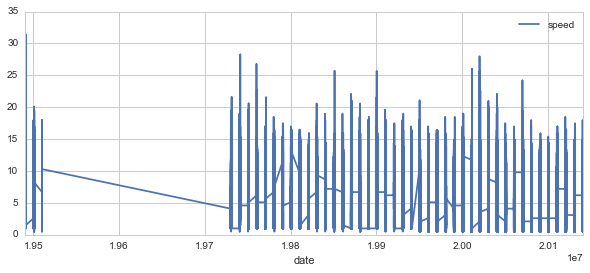

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] < 20150000) ]
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

In [4]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
if not re.findall(ur'[\u4e00-\u9fff]+', uipath): 
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

In [5]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360)

In [6]:
# Data Selection
# Marham, date >1973
# Ciampino, date： 1973~2014
if "ciampino" not in ipath: 
    df = df[ (df['date'] > 19730000) & (df['date'] < 20150000)]
    df = df[(df['HrMn'] % 100 <= 0.1)]
#     df = df[(df['type'] == 'FM-12')]
#     df = df[(df['HrMn'] % 1200 == 0)]
else: 
    # For Roma Ciampino
    df = df[ (df['date'] > 19720000) & (df['date'] < 20150000)]
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]

In [7]:
df.describe()

,date,HrMn,dir,speed_mps,speed
count,343099.000000,343099.000000,343099.000000,343099.000000,343099.000000
mean,19939181.762695,1153.920880,184.183166,4.757138,9.254865
std,121813.350636,688.579023,94.609425,2.701444,5.246005
min,19730101.000000,0.000000,0.000000,0.500000,1.000000
25%,19840101.000000,600.000000,120.000000,2.600000,5.000000
50%,19940218.000000,1200.000000,200.000000,4.600000,9.000000
75%,20050125.000000,1700.000000,250.000000,6.200000,12.000000
max,20141231.000000,2300.000000,350.000000,28.300000,55.000000


## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,,
19741212,19741212,1000,FM-12,160,28.3,55,44,46
20020128,20020128,1700,FM-12,240,28.0,54,27,27
19760102,19760102,2300,FM-12,270,26.8,52,8,6
20011228,20011228,1400,FM-12,280,26.0,51,25,30
19900223,19900223,1000,SY-MT,290,25.7,50,43,45
19851113,19851113,900,FM-12,220,25.7,50,40,45
20070118,20070118,1300,FM-12,270,24.2,47,17,4
19760103,19760103,0,FM-12,270,23.7,46,-6,7
20021027,20021027,1000,FM-12,250,22.6,44,10,32


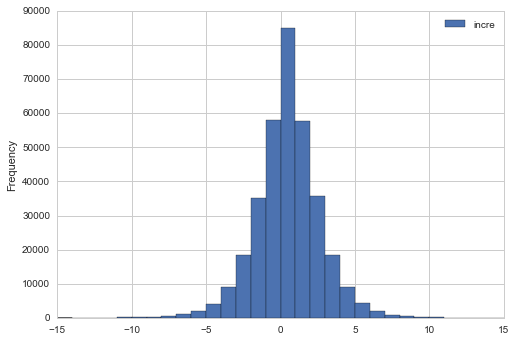

In [8]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [9]:
# Simple Artefacts Handling
df =  df[ (df['incre'] < 20)&(df['incre_reverse'] < 20)]
df = df[df['dir'] % 10 <= 0.1]

After Simple Aretefacts Handling

In [10]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,,
19760102,19760102,2300,FM-12,270,26.8,52,8,6
20070118,20070118,1300,FM-12,270,24.2,47,17,4
19760103,19760103,0,FM-12,270,23.7,46,-6,7
19760102,19760102,2200,FM-12,240,22.7,44,13,-8
20040320,20040320,1600,FM-12,250,22.1,43,3,8
20070118,20070118,1500,FM-12,270,22.1,43,-4,3
19900226,19900226,700,FM-12,230,22.1,43,9,18
19870327,19870327,1400,SY-MT,220,22.1,43,7,3
19900125,19900125,1700,SY-MT,250,21.6,42,3,4


### 1.3.2 Sampling Equality, and Time Shift Comparison

1100    14656
1400    14630
1600    14624
1000    14589
1300    14587
900     14569
1500    14560
1700    14508
800     14456
1200    14448
1900    14262
2000    14246
700     14199
2300    14178
2200    14158
1800    14143
2100    14139
100     14109
0       14053
200     14050
400     14029
500     14003
300     13971
600     13901
Name: HrMn, dtype: int64

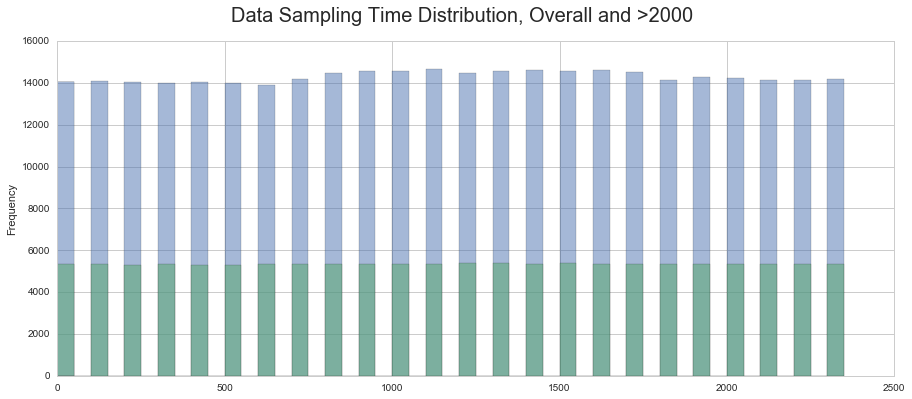

In [11]:
# Ensure data sampled equally
display(df['HrMn'].value_counts())
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)
df['HrMn'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['HrMn'].plot(kind='hist', alpha=0.5,figsize=(15, 6),bins=bins)

plt.suptitle('Data Sampling Time Distribution, Overall and >2000', fontsize = 20)

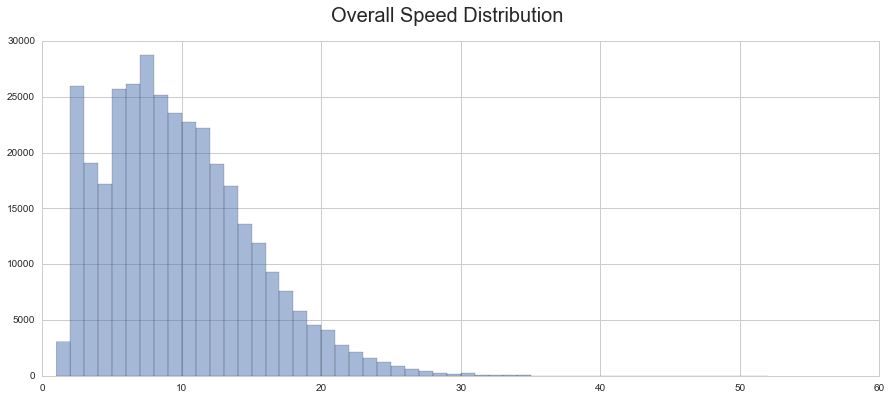

In [12]:
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
plt.suptitle('Overall Speed Distribution', fontsize = 20)

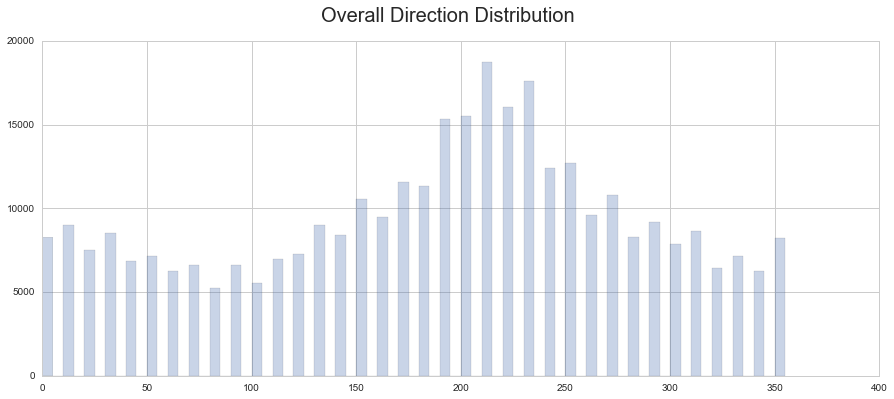

In [13]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df['dir'].hist(bins=bins, alpha=0.3,figsize=(15, 6))
plt.suptitle('Overall Direction Distribution', fontsize = 20)

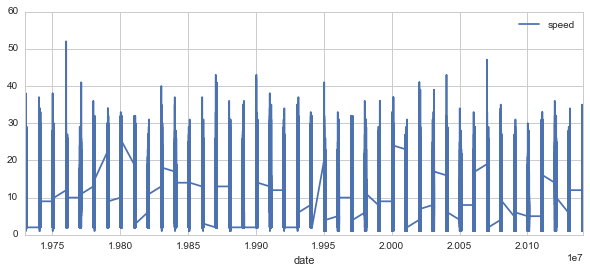

In [14]:
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

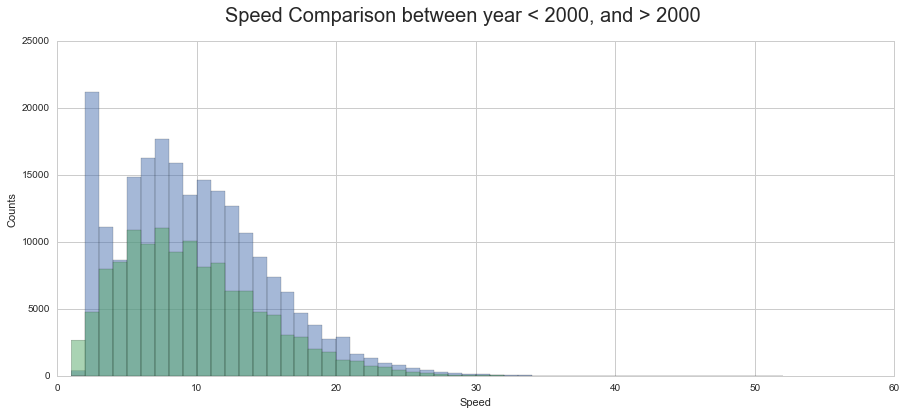

In [15]:
# Comparison between year < 2000, and > 2000, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df_temp = df[df['date'] < 20000000]
df_temp['speed'].hist(bins=bins,alpha = 0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['speed'].hist(bins=bins, alpha = 0.5,figsize=(15, 6))

plt.xlabel("Speed")
plt.ylabel("Counts")
plt.suptitle('Speed Comparison between year < 2000, and > 2000', fontsize = 20)

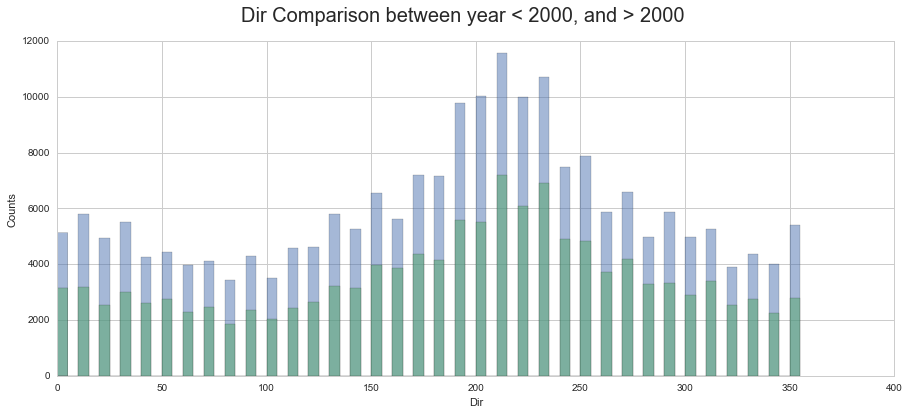

In [16]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df_temp = df[df['date'] < 20000000]
df_temp['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.xlabel("Dir")
plt.ylabel("Counts")
plt.suptitle('Dir Comparison between year < 2000, and > 2000', fontsize = 20)

In [17]:
def plot_speed_and_angle_distribution(df, title = None):
    plt.subplot(1,2,1)
    bins = np.arange(0, 40 + 1, 1)
    df['speed'].hist(bins=bins,figsize=(15, 4))
    plt.xlabel("Speed")
    
    plt.subplot(1,2,2)    
    bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
    df['dir'].hist(bins=bins, alpha=0.3, figsize=(15, 4))
    plt.xlabel("Direction")
    if title:
        plt.suptitle(title)
    plt.show()

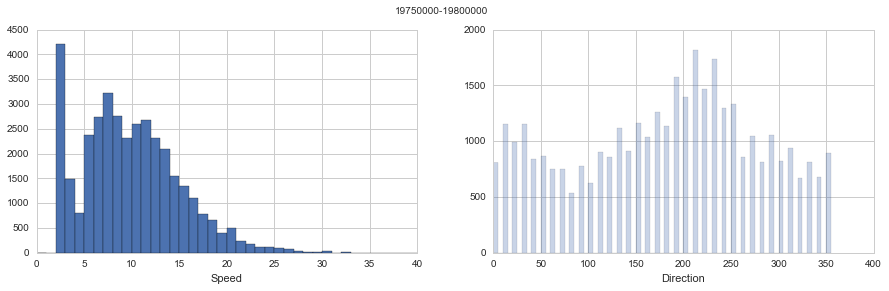

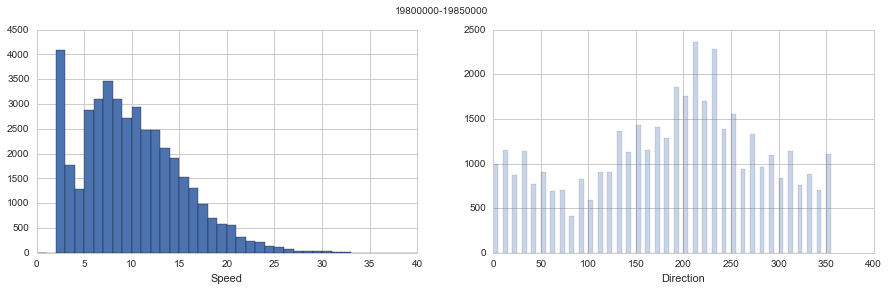

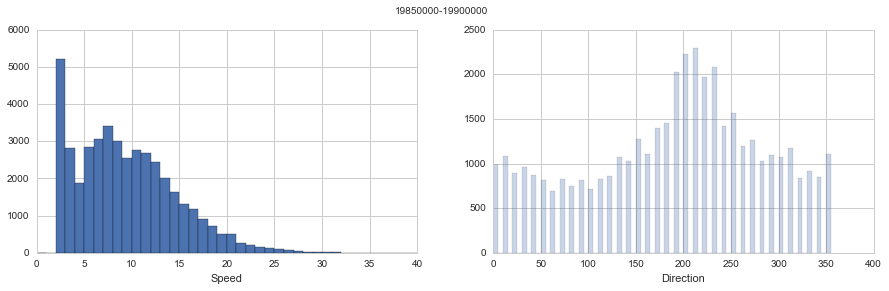

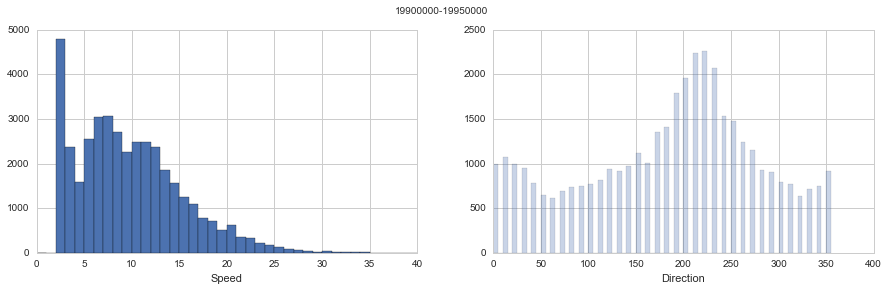

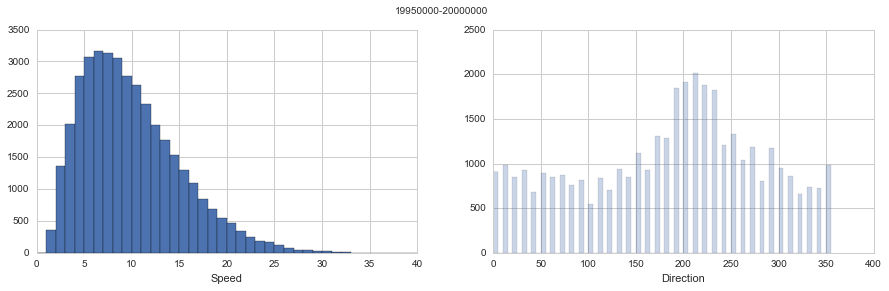

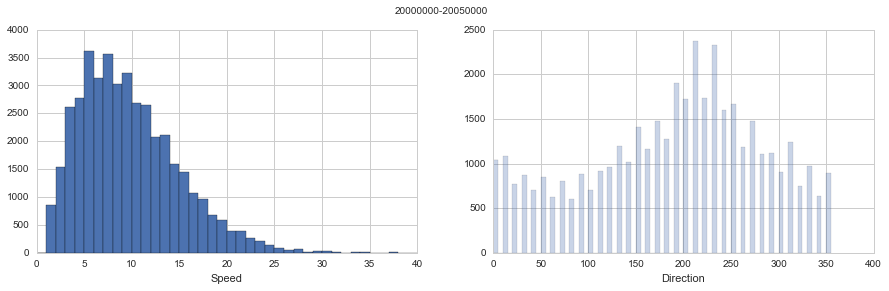

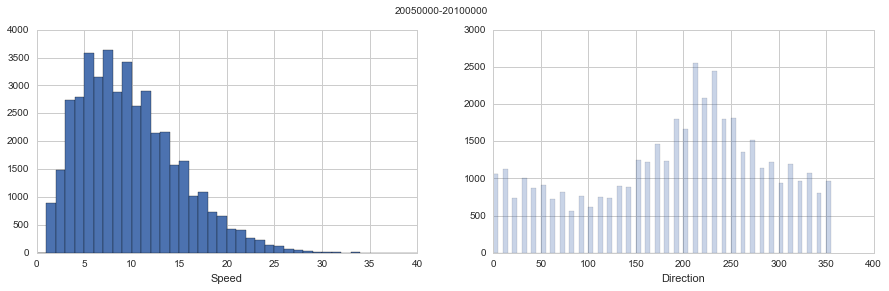

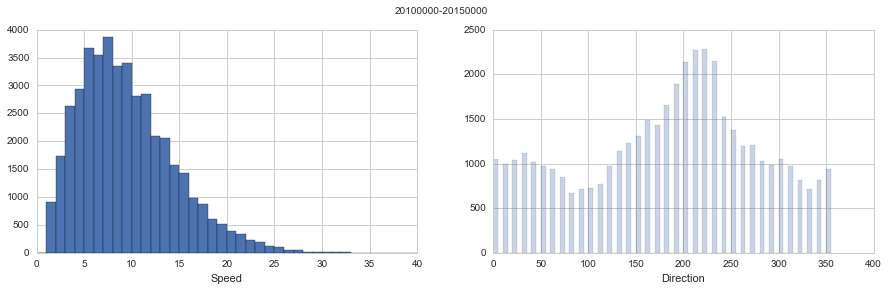

In [18]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19750000,20150000,50000):
        end_time = start_time + 50000 
        sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
        title = str(start_time) +'-' + str(end_time)
        plot_speed_and_angle_distribution(sub_df, title)
        plt.show()
        
check_time_shift(df)

## 1.4 Re-select time range, Data Conversion, and overview of the clean dataset

In [19]:
# if "ciampino" in ipath: 
#     # For Ciampino
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "marham" in ipath:
#     # speed still suffers from odd-even bias
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "boscombe" in ipath:
#     # speed still suffers from odd-even bias
#     df = df[ (df['date'] >= 20100000) & (df['date'] < 20150000)]
# else: 
#     # For Tiree, non is stable
#     df = df[ (df['date'] >= 20050000) & (df['date'] < 20150000)]
    
df = df[ (df['date'] >= 20100000) & (df['date'] < 20150000)]

### 1.4.1 Overview

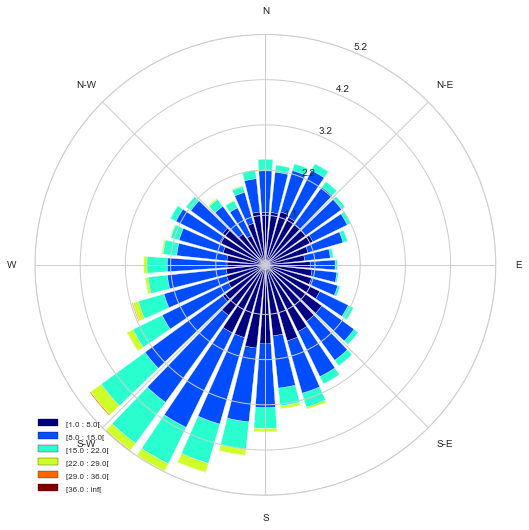

In [20]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

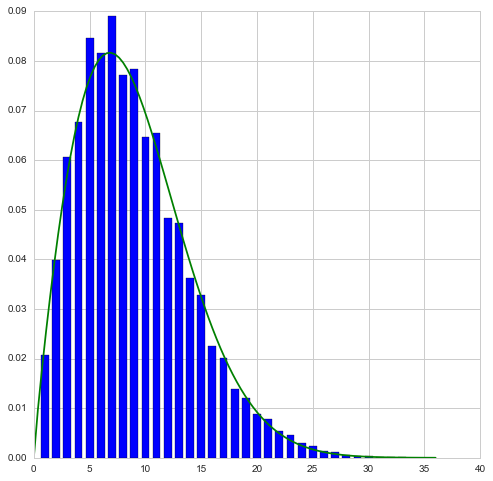

In [21]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [22]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 1.8885275205732672, 0, 10.130396985381438)
(1, 1.8885275205732672, 0, 10.130396985381438)


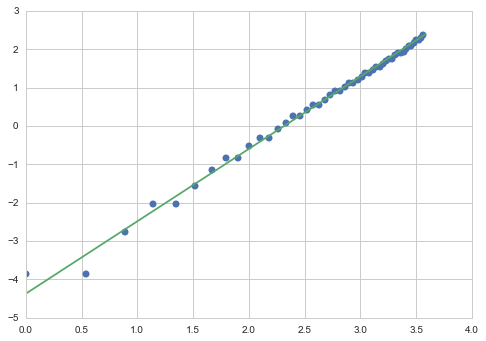

In [23]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [24]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)

In [25]:
df['dir'].value_counts().sort_index()

0       712
10      674
20      845
30      939
40      973
50     1017
60     1113
70     1042
80      994
90     1048
100     944
110     816
120     712
130     815
140     972
150    1047
160     982
170    1032
180    1204
190    1195
200    1372
210    1523
220    2146
230    2278
240    2273
250    2136
260    1894
270    1653
280    1431
290    1485
300    1312
310    1235
320    1135
330     969
340     768
350     726
Name: dir, dtype: int64

### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [26]:
def randomize_angle(df):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-5,5))% 360)

    bins=np.arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

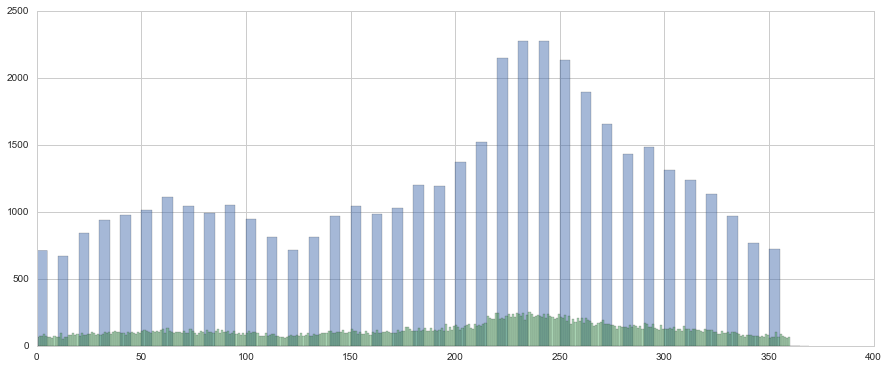

In [27]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df)

### 1.4.4 Generate (x,y) from (speed,dir)

-1.69705294597 -2.0133767211


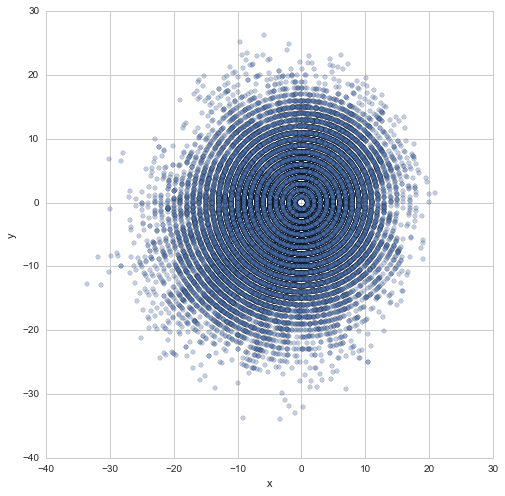

In [28]:
df['x'] = df['speed'] * np.cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * np.sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

# 2. Create Input, speed_set

In [29]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
number_of_gaussian = 3

In [30]:
fitting_range = []
for i in np.arange(-20, 21, 1):
    for j in np.arange(-20, 21, 1):
        fitting_range.append([i,j])

# 3. Kernel Density Estimation

In [31]:
sample = speed_set
kde = KernelDensity(bandwidth=1).fit(sample) # need to consider the bandwidth for different sites

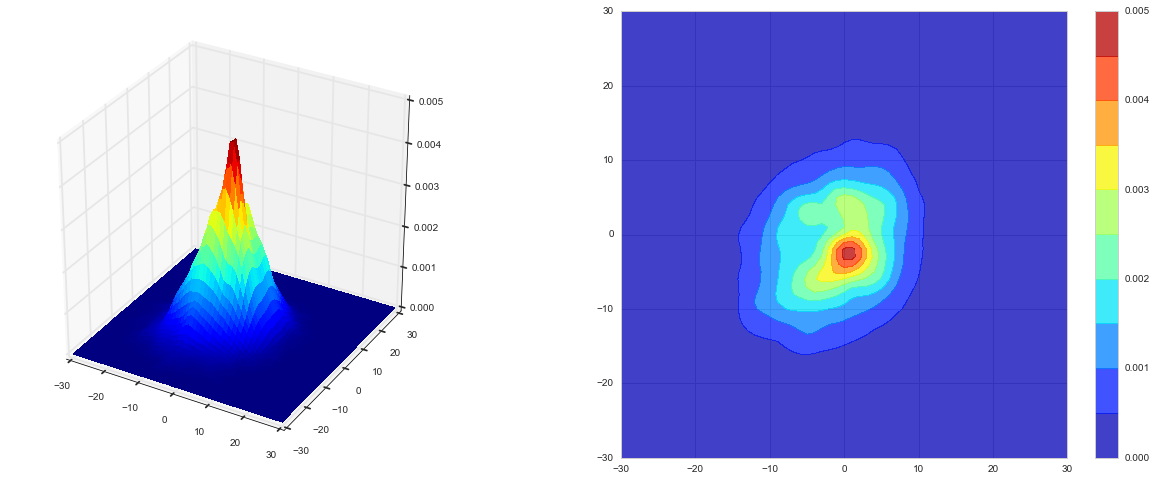

In [32]:
# Plot jPDF
X = Y = np.arange(-30, 31, 1)
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)

# 4. GMM Estimation, using EM algo

In [33]:
sample= speed_set

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

print clf.converged_

for i in xrange(clf.n_components):
    print clf.weights_[i], clf.means_[i], clf.covars_[i]

True
0.335651733733 [-0.42151587  3.16718427] [[ 33.41007721   2.06106089]
 [  2.06106089  34.78182502]]
0.363275048021 [ 1.41841367 -3.98168124] [[ 26.40501344   6.35605415]
 [  6.35605415  39.25670568]]
0.301073218247 [-6.87820963 -5.41397264] [[ 39.46284527   4.79221769]
 [  4.79221769  45.90842054]]


In [55]:
gmm_em_result = read_gmm_em_result(clf)

GMM EM Result:
(0.33565173373274848, -0.42151587214767783, 3.167184269147009, 5.7801450857629915, 5.8976118063649174, 0.060461079804967816)
(0.36327504802073096, 1.418413674400464, -3.9816812439871714, 5.1385808781480398, 6.2655171917897103, 0.19741832663089423)
(0.30107321824652122, -6.878209627638857, -5.413972642499682, 6.2819459778715006, 6.7755752918283374, 0.11258905264183287)


GMM Plot Result
0.335651733733 [[-0.42151587  3.16718427]] [ 5.6501119   6.02230336] 144.203131075
0.363275048021 [[ 1.41841367 -3.98168124]] [ 4.87776142  6.4706385 ] 157.656422176
0.301073218247 [[-6.87820963 -5.41397264]] [ 6.07540442  6.96137392] 151.960503316


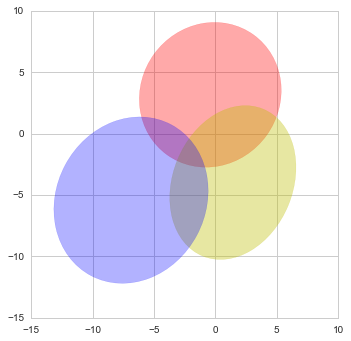

In [35]:
plot_gmm_ellipses(gmm_em_result)

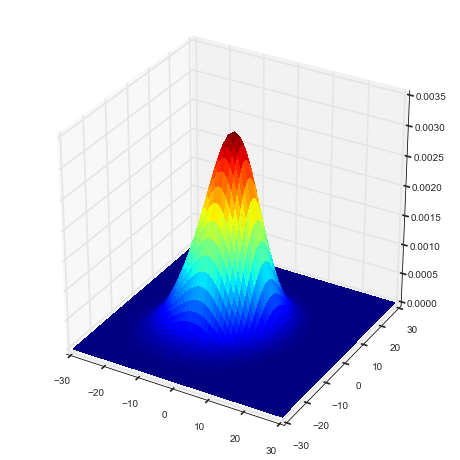

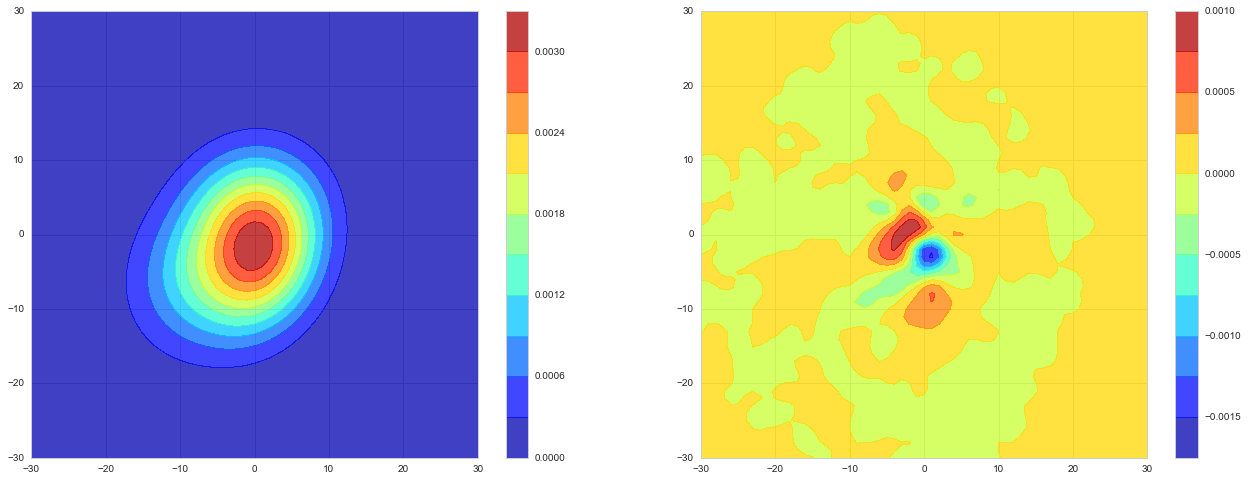

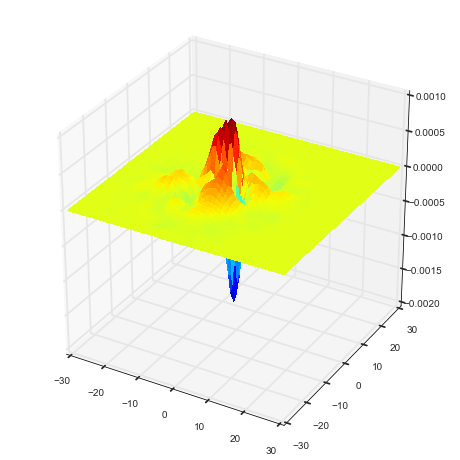

In [36]:
X = Y = np.arange(-30, 31, 1)
Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))
plot_3d_prob_density(X,Y,Z)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,Z,ax1)

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = np.exp(clf.score_samples(points)[0])
    return gmm_vals - kde_vals

Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)
plot_3d_prob_density(X,Y,Z)

## GMM, EM VS. KDE

In [37]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])
kde_result = np.exp(kde.score_samples(points))

### RMSE & R Square

In [38]:
error_array = np.power(gmm_pdf_result - kde_result,2)
MSE = np.average(error_array)
RMSE = np.sqrt(MSE)

print RMSE
R_square_of(MSE, kde_result)

0.000173076422682


0.95574783672627905

# 5. Least Square Prob Estimation

In [39]:
if not 'kde' in globals():
    sample = speed_set
    kde = KernelDensity(bandwidth=1.0).fit(sample)

In [40]:
points = fitting_range

In [41]:
# very slow if the dataset is too large, e.g. 100,000
if not kde_result.all():
    kde_result = np.exp(kde.score_samples(points))
print kde_result
print len(kde_result)

[  2.19260146e-05   3.09397144e-05   3.95426465e-05 ...,   6.49930309e-14
   4.15641706e-16   1.00228903e-18]
1681


In [42]:
gmm_em_result = read_gmm_em_result(clf)

GMM EM Result:
(0.33565173373274848, -0.42151587214767783, 3.167184269147009, 5.7801450857629915, 5.8976118063649174, 0.060461079804967816)
(0.36327504802073096, 1.418413674400464, -3.9816812439871714, 5.1385808781480398, 6.2655171917897103, 0.19741832663089423)
(0.30107321824652122, -6.878209627638857, -5.413972642499682, 6.2819459778715006, 6.7755752918283374, 0.11258905264183287)


In [43]:
def GMM_MSE_log(gmm, kde_result): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Calculate the sum of square error
    error_array = np.power(mixed_model_pdf(points) - kde_result,2) # kde returns log prob, need to convert it
    mse = np.average(error_array)
    result = np.log(mse)
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

# sum of every 6th element, which is the fraction of each gaussian
cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
        {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
       ] 
bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_MSE_log(x0, kde_result),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

  status: 0
 success: True
    njev: 60
    nfev: 1213
     fun: -18.231713914311026
       x: array([ 0.38157548, -0.38209491,  4.17960706,  6.76412986,  4.42597561,
        0.17318298,  0.08630163,  1.11989208, -2.96924571,  2.62392221,
        2.28517862,  0.31125336,  0.53212288, -2.51347851, -6.30748634,
        7.45837964,  5.43489753,  0.21204456])
 message: 'Optimization terminated successfully.'
     jac: array([  1.27387857e+00,  -2.38418579e-07,  -2.38418579e-07,
        -4.76837158e-07,   2.38418579e-07,   7.15255737e-07,
         1.27388644e+00,  -2.38418579e-07,   2.38418579e-07,
        -2.38418579e-07,   0.00000000e+00,   4.76837158e-07,
         1.27387691e+00,  -2.38418579e-07,   7.15255737e-07,
        -2.38418579e-07,  -4.76837158e-07,  -2.38418579e-07,
         0.00000000e+00])
     nit: 60

## LRMSE VS. KDE

In [44]:
MSE = exp(result.fun)
MSE_log = result.fun
R_square = R_square_of(MSE, kde_result)

print MSE, MSE_log
print R_square

1.208000882e-08 -18.2317139143
0.982154614377


In [45]:
# RMSE / Mode
RMSE = np.sqrt(exp(result.fun))
print RMSE/np.max(kde_result)
print RMSE/np.mean(kde_result)

0.0233470388121
0.18745832593


In [46]:
import pprint
pp = pprint.PrettyPrinter()

gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
pp.pprint(gmm)

[array([ 0.53212288, -2.51347851, -6.30748634,  7.45837964,  5.43489753,
        0.21204456]),
 array([ 0.38157548, -0.38209491,  4.17960706,  6.76412986,  4.42597561,
        0.17318298]),
 array([ 0.08630163,  1.11989208, -2.96924571,  2.62392221,  2.28517862,
        0.31125336])]


GMM Plot Result
0.532122884707 [[-2.51347851 -6.30748634]] [ 5.1923882   7.62919673] -73.3092296189
0.381575482001 [[-0.38209491  4.17960706]] [ 4.31269099  6.83691519] -79.1902293022
0.0863016332915 [[ 1.11989208 -2.96924571]] [ 2.00258671  2.84546228] -57.0067354989


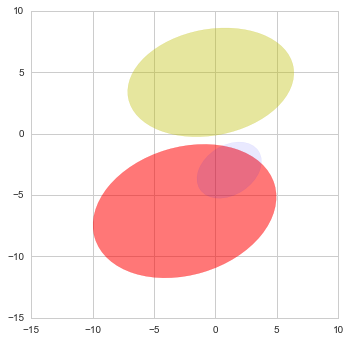

In [47]:
plot_gmm_ellipses(gmm)

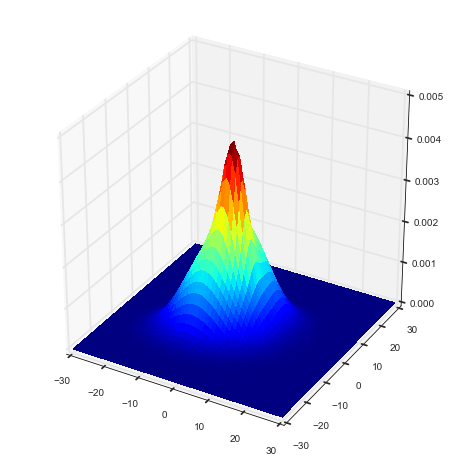

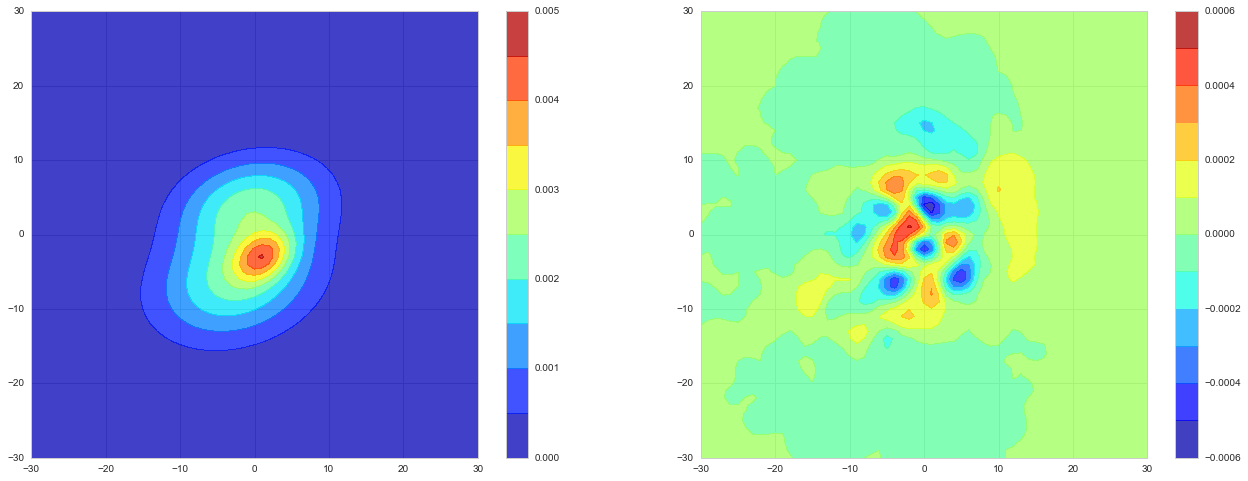

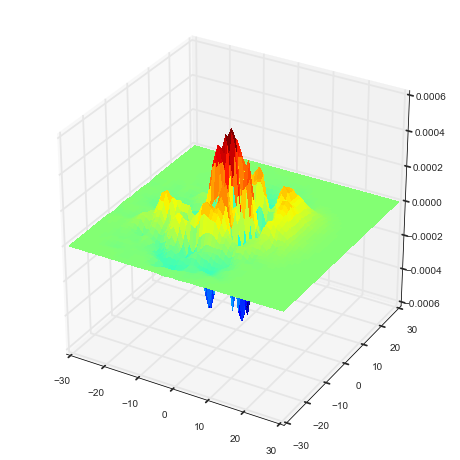

In [48]:
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)

X = Y = np.arange(-30, 31, 1)
Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument
plot_3d_prob_density(X,Y,Z)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,Z,ax1)

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return gmm_vals - kde_vals

Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)
plot_3d_prob_density(X,Y,Z)

In [49]:
from scipy.stats import multivariate_normal

def create_gaussian_2d(meanx,meany,sigx,sigy,rho):
    sigxy = rho*sigx*sigy
    return multivariate_normal(mean=[meanx,meany], cov=[[sigx**2,sigxy],[sigxy,sigy**2]], allow_singular=True)

def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.linspace(0,50)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

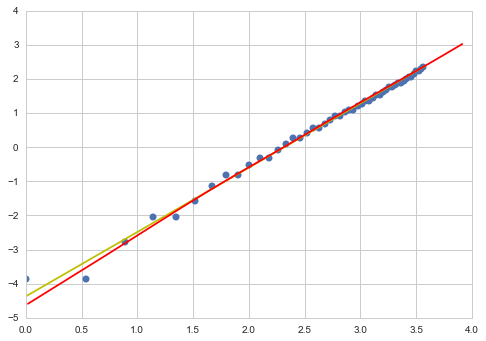

In [50]:
# Plot v-p points, empirical distribution
sample = df.speed
ecdf = sm.distributions.ECDF(sample)
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# Weibull distribution
x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

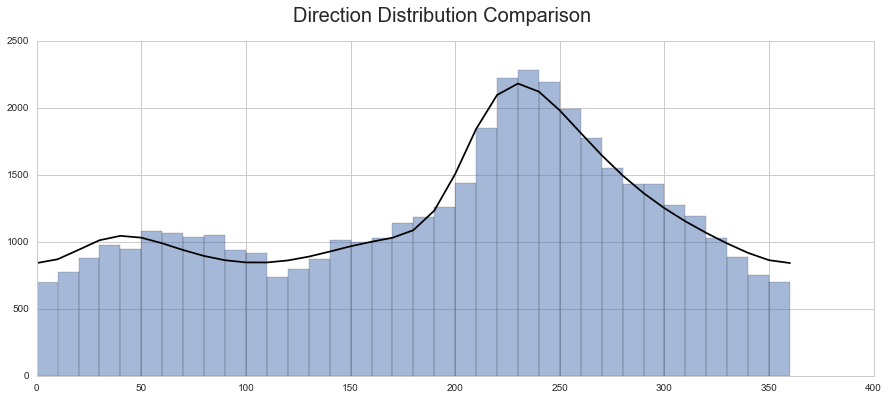

In [51]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-np.pi/36, x_val+np.pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = np.array(zip(*y_vals_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/np.pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

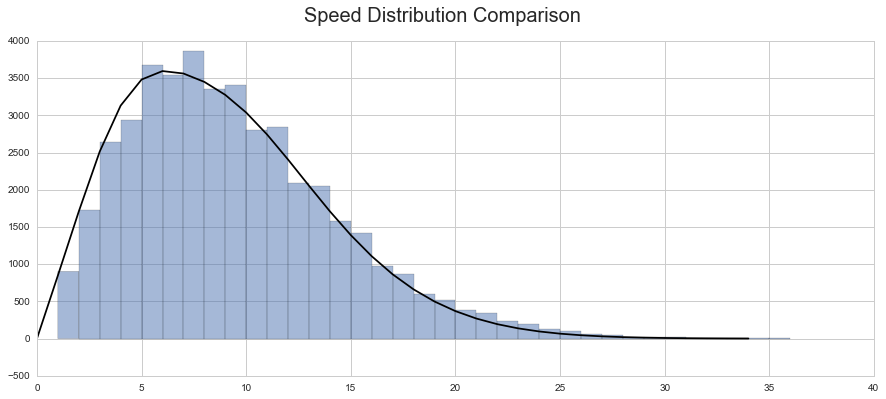

In [52]:
# Calculate Speed Distribution
x_vals = np.arange(0, 35, 1)
y_vals =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[0, 2*np.pi]]) for x_val in x_vals]

x, y_ = x_vals, y_vals
y = np.array(zip(*y_)[0])*len(df.speed)

bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x, y,'-', color='black')
plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [53]:
ssss

NameError: name 'ssss' is not defined

In [ ]:
# Calculate Speed Distribution
# sector_number = 36
# angles = np.linspace(0,2*np.pi, num=sector_number+1)
angles = np.linspace(10,350, num=35)
for angle in angles:
    angle_in_arc = angle*np.pi/180
    angle_in_degree = angle
    
    # Number from observation
    start_angle, end_angle = angle_in_degree-5, angle_in_degree+5
    sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 
    
    # Number from model
    x_vals = np.arange(0, 35, 1)
    y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_in_arc-np.pi/36, angle_in_arc+np.pi/36]]) for x_val in x_vals]
    y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)

    sub_df['speed'].hist(bins=x_vals, alpha=0.5,figsize=(15, 6))
    plt.plot(x_vals, y_vals,'-', color='black')
    
    title = str(start_angle) + '-' +str(end_angle)
    plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 20)
    plt.show()

# Cross Validation, to check the number of ellipse to be fitted

In [ ]:
# if "ciampino" in ipath: 
#     # For Ciampino
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "marham" in ipath:
#     # For Marham
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# else: 
#     # For Tiree, non is stable
#     df = df[ (df['date'] >= 20050000) & (df['date'] < 20150000)]

In [ ]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, printable = True):
    # 1. Create Input, speed_set
    sub_speed_set = np.array(zip(df.x, df.y))
    sample = sub_speed_set
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = KernelDensity(bandwidth=1).fit(sample) 
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    kde_result = np.exp(kde.score_samples(points))
    gmm_em_result = read_gmm_em_result(clf, printable)
        
    # 3. LRMSE fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
 
    result = sp.optimize.minimize(
        lambda x0: GMM_MSE_log(x0, kde_result),
        x0,
        bounds = bonds,
        constraints=cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    MSE = exp(result.fun) # result.fun is logged RMSE
    R_square = R_square_of(MSE, kde_result)
    gmm = group_gmm_param_from_gmm_param_array(result.x)   
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'MSE': MSE,
        'R_square': R_square,
        'number_of_iteration': result.nit}

In [ ]:
## 5-fold cross validation
CV_result_all =[]
for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian

    kf = KFold(len(df), n_folds=5, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, False)

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = np.array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = KernelDensity(bandwidth=1).fit(sample) 
        kde_result_test = np.exp(kde.score_samples(points))

        MSE_test = GMM_MSE_log(result['gmm'], kde_result_test) # log 
        R_square_test = R_square_of(exp(MSE_test), kde_result_test)

        print 'MSE log', np.log(result['MSE']), 'R Square', result['R_square']
        print 'MSE log test', MSE_test, 'R_square test', R_square_test
        CV_result.append([MSE_test,R_square_test])
    CV_result_all.append(CV_result)

In [ ]:
test = np.asarray(CV_result_all)
cv_means=test.mean(axis=1)
x = xrange(1,6)
y=cv_means[:,1]
plt.plot(x, y,'-', color='black')

print cv_means

In [ ]:
x = xrange(1,6)
y=cv_means[:,0]
plt.plot(x, y,'-', color='black')

In [ ]:
sss

In [ ]:
## Train-Validation Set 0.5-0.5 split
for number_of_gaussian in xrange(1,7):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    train, test = train_test_split(df, test_size = 0.5)
    
    sub_df = train
    sub_df_test = test

    plot_speed_and_angle_distribution(sub_df)
    plot_speed_and_angle_distribution(sub_df_test)

    # 1. Train
    # number_of_gaussian = 5
    result = fit_gmm(sub_df, number_of_gaussian)
    plot_gmm_ellipses(result['gmm'])

    # 2. Validate
    # GMM from Train - KDE from Test
    sample = np.array(zip(sub_df_test.x, sub_df_test.y))
    kde_test = KernelDensity(bandwidth=1).fit(sample) 
    kde_result_test = np.exp(kde.score_samples(points))

    MSE_test = GMM_MSE_log(result['gmm'], kde_result_test) # log 
    R_square_test = R_square_of(exp(MSE_test), kde_result_test)

    print 'MSE log', np.log(result['MSE']), 'R Square', result['R_square']
    print 'MSE log test', MSE_test, 'R_square test', R_square_test

In [ ]:
sss

In [ ]:
train, test = train_test_split(df, test_size = 0.2)
kf = KFold(len(train), n_folds=4, shuffle=True)
   
for train_index, test_index in kf:
    sub_df = df.iloc[train_index]
    sub_df_test = df.iloc[test_index]

    plot_speed_and_angle_distribution(sub_df)
    plot_speed_and_angle_distribution(sub_df_test)

    # 1. Train
    number_of_gaussian = 5
    result = fit_gmm(sub_df, number_of_gaussian)
    print 'MSE log', np.log(result['MSE']), 'R Square', result['R_square']
    plot_gmm_ellipses(result['gmm'])

    # 2. Validate
    # GMM from Train - KDE from Test
    sample = np.array(zip(sub_df_test.x, sub_df_test.y))
    kde_test = KernelDensity(bandwidth=1).fit(sample) 
    kde_result_test = np.exp(kde.score_samples(points))

    MSE_test = GMM_MSE_log(result['gmm'], kde_result_test)
    R_square_test = R_square_of(MSE, kde_result_test)

    print 'MSE log test', MSE_test
    print 'R_square', R_square_test

# Time Shift, Loop Through Years to See the Difference

In [ ]:
# for start_time in xrange(19750000,20150000,50000):
#     end_time = start_time + 50000 
#     sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
number_of_gaussian = 5

for i in xrange(1,20):
    sub_df = df.sample(frac=1, replace=True)
    
    # 1. Fitting
    plot_speed_and_angle_distribution(sub_df)
    result = fit_gmm(sub_df, number_of_gaussian)
    print 'MSE log', np.log(result['MSE']), ', R Square', result['R_square']
        
    fig = plt.figure(figsize=(15,8))
    X = Y = np.arange(-30, 31, 1)

    # 2. Plot KDE 
    Z = result['kde_result'].reshape(len(X),len(X)).T
    ax1 = fig.add_subplot(1,3,1)
    plot_2d_prob_density(X,Y,Z,ax1)
    
    # 3. Plot GMM Density
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)
    ax2 = fig.add_subplot(1,3,2)
    plot_2d_prob_density(X,Y,Z,ax2)
    
    # 4. Plot Gmm Ellipse
    ax3 = fig.add_subplot(1,3,3)
    plot_gmm_ellipses(result['gmm'], ax3)